In [1]:
# =====================
# Core Libraries
# =====================
import numpy as np
import pandas as pd

# =====================
# Visualization
# =====================
import seaborn as sns
import matplotlib.pyplot as plt

# =====================
# Preprocessing
# =====================
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer, StandardScaler, PolynomialFeatures
from sklearn.impute import KNNImputer

# =====================
# Model Selection & Tuning
# =====================
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

# =====================
# Regression Models
# =====================
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neural_network import MLPRegressor

# =====================
# Classification Models
# =====================
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

# =====================
# Pipelines
# =====================
from sklearn.pipeline import Pipeline

# =====================
# Metrics
# =====================
from sklearn.metrics import (confusion_matrix, roc_curve, precision_recall_curve,
                             roc_auc_score, precision_score,
                             recall_score, f1_score)

# =====================
# Other Useful Tools
# =====================
from sklearn.datasets import make_regression
from numpy import log1p


In [2]:
data = pd.read_csv("train.csv")

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 12 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           750000 non-null  int64  
 1   Podcast_Name                 750000 non-null  object 
 2   Episode_Title                750000 non-null  object 
 3   Episode_Length_minutes       662907 non-null  float64
 4   Genre                        750000 non-null  object 
 5   Host_Popularity_percentage   750000 non-null  float64
 6   Publication_Day              750000 non-null  object 
 7   Publication_Time             750000 non-null  object 
 8   Guest_Popularity_percentage  603970 non-null  float64
 9   Number_of_Ads                749999 non-null  float64
 10  Episode_Sentiment            750000 non-null  object 
 11  Listening_Time_minutes       750000 non-null  float64
dtypes: float64(5), int64(1), object(6)
memory usage: 68.7+ MB


In [4]:
data.isna().sum()

id                                  0
Podcast_Name                        0
Episode_Title                       0
Episode_Length_minutes          87093
Genre                               0
Host_Popularity_percentage          0
Publication_Day                     0
Publication_Time                    0
Guest_Popularity_percentage    146030
Number_of_Ads                       1
Episode_Sentiment                   0
Listening_Time_minutes              0
dtype: int64

In [5]:
data.columns


Index(['id', 'Podcast_Name', 'Episode_Title', 'Episode_Length_minutes',
       'Genre', 'Host_Popularity_percentage', 'Publication_Day',
       'Publication_Time', 'Guest_Popularity_percentage', 'Number_of_Ads',
       'Episode_Sentiment', 'Listening_Time_minutes'],
      dtype='object')

C:\Users\ASUS\AppData\Local\Temp\ipykernel_9592\1396035614.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=genre_means, x='Genre', y='Listening_Time_minutes', palette='viridis')


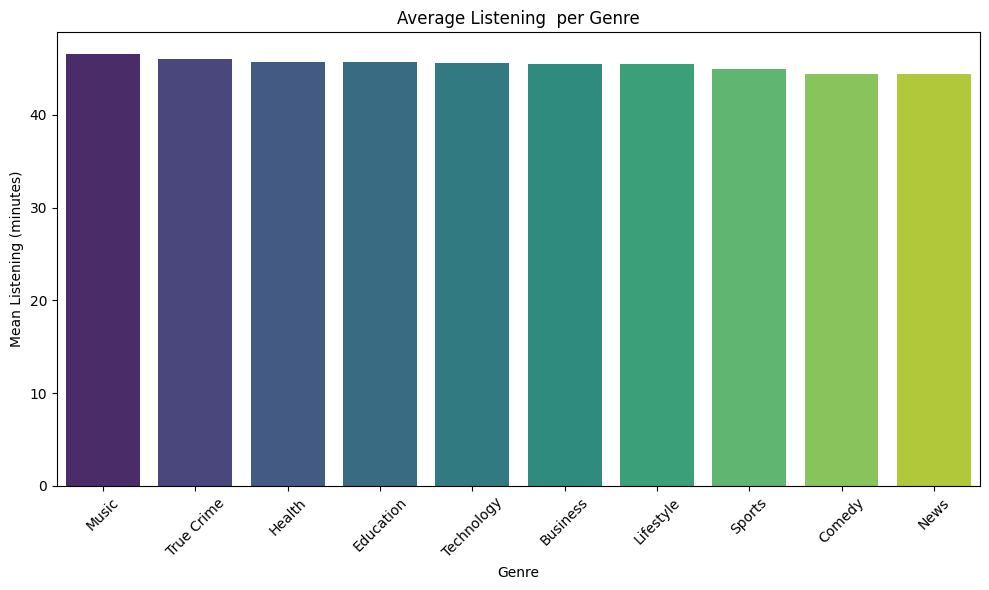

In [6]:
genre_means = data.groupby('Genre')['Listening_Time_minutes'].mean().reset_index()

# Sort values by mean duration
genre_means = genre_means.sort_values(by='Listening_Time_minutes', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=genre_means, x='Genre', y='Listening_Time_minutes', palette='viridis')

# Add titles and labels
plt.title('Average Listening  per Genre')
plt.ylabel('Mean Listening (minutes)')
plt.xlabel('Genre')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

C:\Users\ASUS\AppData\Local\Temp\ipykernel_9592\4029125348.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=genre_means, x='Episode_Sentiment', y='Listening_Time_minutes', palette='viridis')


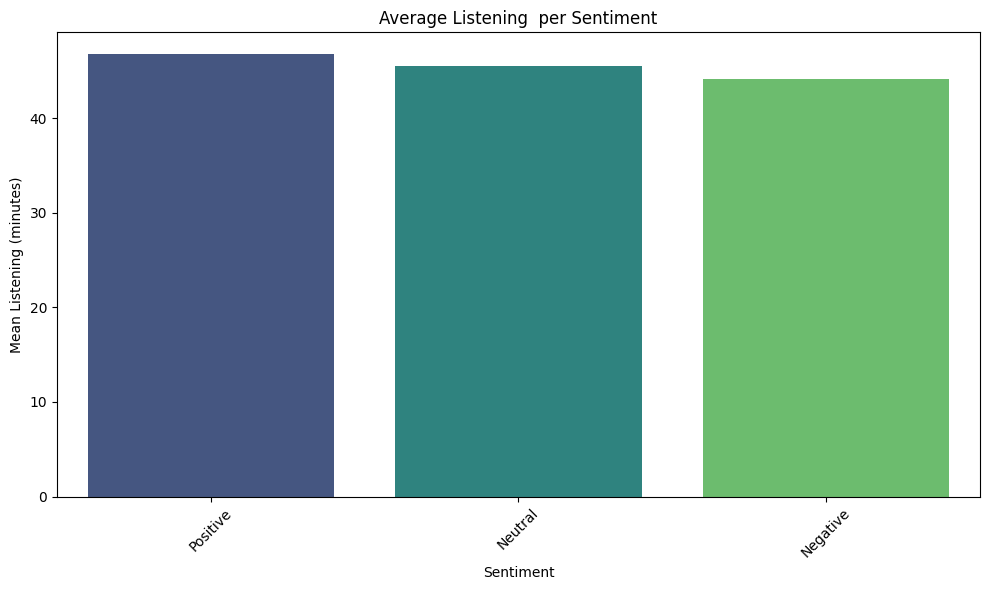

In [7]:
genre_means = data.groupby('Episode_Sentiment')['Listening_Time_minutes'].mean().reset_index()

# Sort values by mean duration
genre_means = genre_means.sort_values(by='Listening_Time_minutes', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=genre_means, x='Episode_Sentiment', y='Listening_Time_minutes', palette='viridis')

# Add titles and labels
plt.title('Average Listening  per Sentiment')
plt.ylabel('Mean Listening (minutes)')
plt.xlabel('Sentiment')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

C:\Users\ASUS\AppData\Local\Temp\ipykernel_9592\1480806478.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=genre_means, x='Podcast_Name', y='Listening_Time_minutes', palette='viridis')


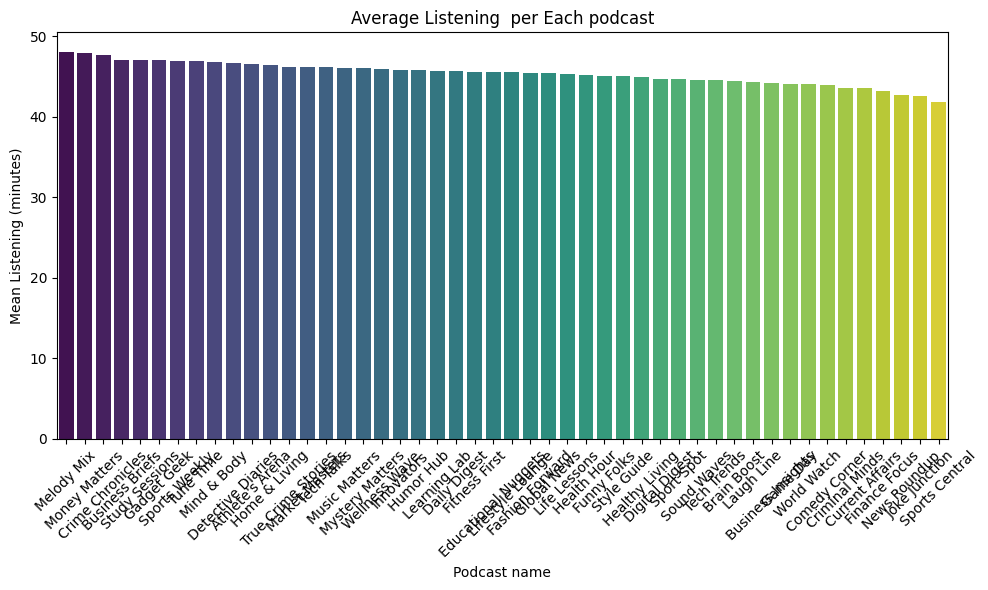

In [8]:
genre_means = data.groupby('Podcast_Name')['Listening_Time_minutes'].mean().reset_index()

# Sort values by mean duration
genre_means = genre_means.sort_values(by='Listening_Time_minutes', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=genre_means, x='Podcast_Name', y='Listening_Time_minutes', palette='viridis')

# Add titles and labels
plt.title('Average Listening  per Each podcast')
plt.ylabel('Mean Listening (minutes)')
plt.xlabel('Podcast name')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

C:\Users\ASUS\AppData\Local\Temp\ipykernel_9592\4123741335.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = data.groupby('Popularity_Bin')['Listening_Time_minutes'].mean().reset_index()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_9592\4123741335.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=grouped, x='Popularity_Bin', y='Listening_Time_minutes', palette='Blues_d')


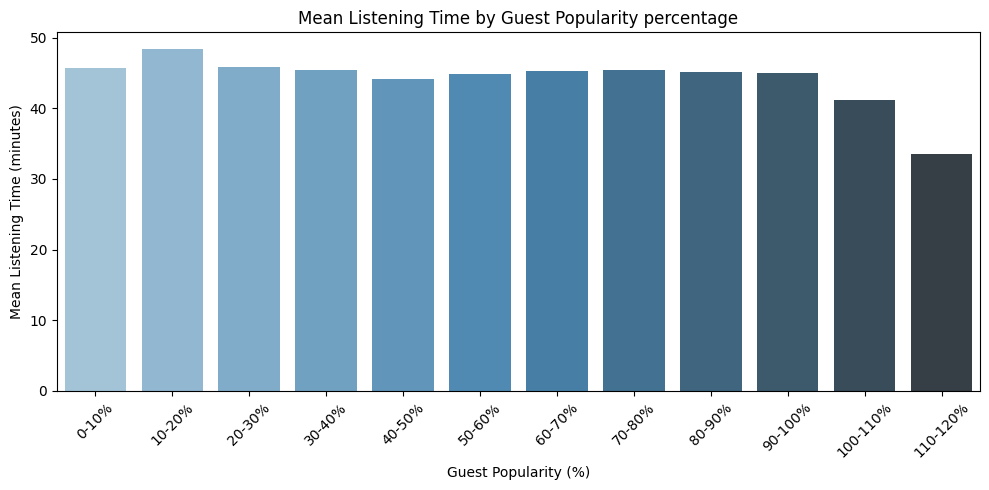

In [9]:
# Bin the Guest_Popularity_percentage into 10% intervals
data['Popularity_Bin'] = pd.cut(data['Guest_Popularity_percentage'],
                                bins=range(0, 130, 10),  # 0–100 in steps of 10
                                right=False,  # 0–10 includes 0 but not 10
                                labels=[f"{i}-{i+10}%" for i in range(0, 120, 10)])

grouped = data.groupby('Popularity_Bin')['Listening_Time_minutes'].mean().reset_index()
plt.figure(figsize=(10, 5))
sns.barplot(data=grouped, x='Popularity_Bin', y='Listening_Time_minutes', palette='Blues_d')

plt.title("Mean Listening Time by Guest Popularity percentage")
plt.xlabel("Guest Popularity (%)")
plt.ylabel("Mean Listening Time (minutes)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


C:\Users\ASUS\AppData\Local\Temp\ipykernel_9592\3754026561.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = data.groupby('Popularity_Bin')['Host_Popularity_percentage'].mean().reset_index()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_9592\3754026561.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=grouped, x='Popularity_Bin', y='Host_Popularity_percentage', palette='Blues_d')


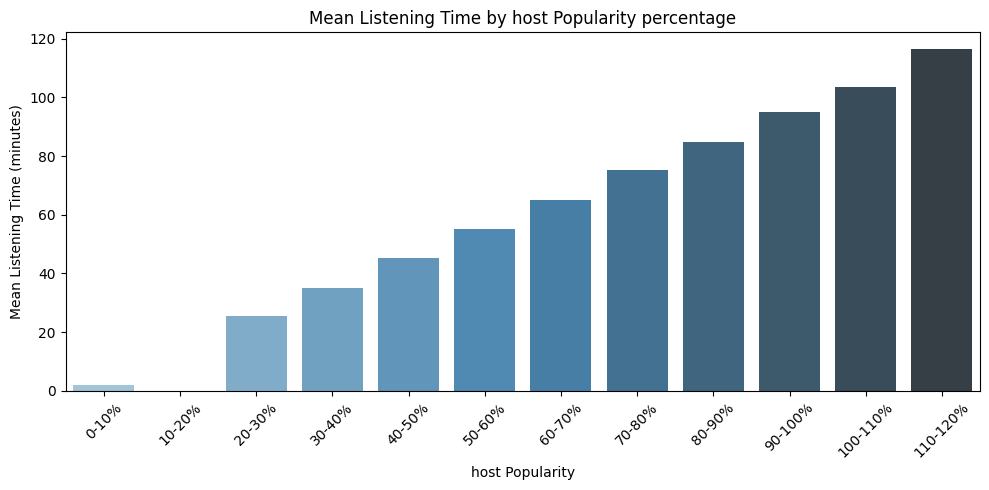

In [10]:

# Bin the Guest_Popularity_percentage into 10% intervals
data['Popularity_Bin'] = pd.cut(data['Host_Popularity_percentage'],
                                bins=range(0, 130, 10),  # 0–100 in steps of 10
                                right=False,  # 0–10 includes 0 but not 10
                                labels=[f"{i}-{i+10}%" for i in range(0, 120, 10)])

grouped = data.groupby('Popularity_Bin')['Host_Popularity_percentage'].mean().reset_index()
plt.figure(figsize=(10, 5))
sns.barplot(data=grouped, x='Popularity_Bin', y='Host_Popularity_percentage', palette='Blues_d')

plt.title("Mean Listening Time by host Popularity percentage")
plt.xlabel("host Popularity")
plt.ylabel("Mean Listening Time (minutes)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [11]:
data["Episode_Title"] = data["Episode_Title"].str.replace("Episode", "", regex=False).astype(int)


In [12]:
data

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes,Popularity_Bin
0,0,Mystery Matters,98,NaN,True Crime,74.81,Thursday,Night,NaN,0.0,Positive,31.41998,70-80%
1,1,Joke Junction,26,119.80,Comedy,66.95,Saturday,Afternoon,75.95,2.0,Negative,88.01241,60-70%
2,2,Study Sessions,16,73.90,Education,69.97,Tuesday,Evening,8.97,0.0,Negative,44.92531,60-70%
3,3,Digital Digest,45,67.17,Technology,57.22,Monday,Morning,78.70,2.0,Positive,46.27824,50-60%
4,4,Mind & Body,86,110.51,Health,80.07,Monday,Afternoon,58.68,3.0,Neutral,75.61031,80-90%
...,...,...,...,...,...,...,...,...,...,...,...,...,...
749995,749995,Learning Lab,25,75.66,Education,69.36,Saturday,Morning,NaN,0.0,Negative,56.87058,60-70%
749996,749996,Business Briefs,21,75.75,Business,35.21,Saturday,Night,NaN,2.0,Neutral,45.46242,30-40%
749997,749997,Lifestyle Lounge,51,30.98,Lifestyle,78.58,Thursday,Morning,84.89,0.0,Negative,15.26000,70-80%
749998,749998,Style Guide,47,108.98,Lifestyle,45.39,Thursday,Morning,93.27,0.0,Negative,100.72939,40-50%


C:\Users\ASUS\AppData\Local\Temp\ipykernel_9592\3416431022.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=episode_means, x='Episode_Title', y='Listening_Time_minutes', palette='viridis')


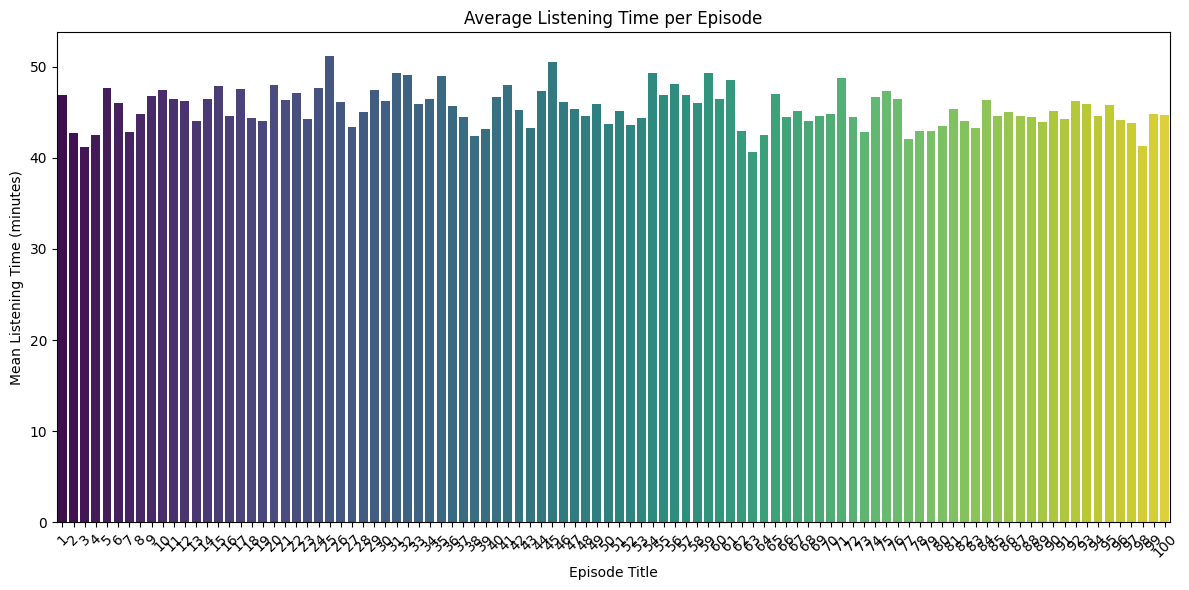

In [13]:
# Compute mean Listening_Time_minutes per episode
episode_means = data.groupby('Episode_Title')['Listening_Time_minutes'].mean().reset_index()

# Sort values by mean duration (descending)
episode_means = episode_means.sort_values(by='Listening_Time_minutes', ascending=False)

# Plot
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.barplot(data=episode_means, x='Episode_Title', y='Listening_Time_minutes', palette='viridis')

# Annotate
plt.title('Average Listening Time per Episode')
plt.ylabel('Mean Listening Time (minutes)')
plt.xlabel('Episode Title')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Feature engineering:

In [14]:
data.drop(["id", "Podcast_Name"], axis=1, inplace=True)


In [15]:
categorical_cols = ['Genre', 'Publication_Day', 'Publication_Time', 'Episode_Sentiment']

# One-hot encode and concatenate
data_ohe = pd.get_dummies(data, columns=categorical_cols, prefix=categorical_cols)

In [16]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer


cols_for_impute = ['Episode_Length_minutes' , 'Guest_Popularity_percentage' , 'Number_of_Ads']

imputer = IterativeImputer(random_state=42)
data_ohe[cols_for_impute] = imputer.fit_transform(data_ohe[cols_for_impute])


In [17]:
data_ohe

,Episode_Title,Episode_Length_minutes,Host_Popularity_percentage,Guest_Popularity_percentage,Number_of_Ads,Listening_Time_minutes,Popularity_Bin,Genre_Business,Genre_Comedy,Genre_Education,...,Publication_Day_Thursday,Publication_Day_Tuesday,Publication_Day_Wednesday,Publication_Time_Afternoon,Publication_Time_Evening,Publication_Time_Morning,Publication_Time_Night,Episode_Sentiment_Negative,Episode_Sentiment_Neutral,Episode_Sentiment_Positive
0,98,66.620916,74.81,51.991335,0.0,31.41998,70-80%,False,False,False,...,True,False,False,False,False,False,True,False,False,True
1,26,119.800000,66.95,75.950000,2.0,88.01241,60-70%,False,True,False,...,False,False,False,True,False,False,False,True,False,False
2,16,73.900000,69.97,8.970000,0.0,44.92531,60-70%,False,False,True,...,False,True,False,False,True,False,False,True,False,False
3,45,67.170000,57.22,78.700000,2.0,46.27824,50-60%,False,False,False,...,False,False,False,False,False,True,False,False,False,True
4,86,110.510000,80.07,58.680000,3.0,75.61031,80-90%,False,False,False,...,False,False,False,True,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749995,25,75.660000,69.36,51.907535,0.0,56.87058,60-70%,False,False,True,...,False,False,False,False,False,True,False,True,False,False
749996,21,75.750000,35.21,52.249184,2.0,45.46242,30-40%,True,False,False,...,False,False,False,False,False,False,True,False,True,False
749997,51,30.980000,78.58,84.890000,0.0,15.26000,70-80%,False,False,False,...,True,False,False,False,False,True,False,True,False,False
749998,47,108.980000,45.39,93.270000,0.0,100.72939,40-50%,False,False,False,...,True,False,False,False,False,True,False,True,False,False


In [18]:
data_ohe.drop(columns="Popularity_Bin" , inplace=True)

In [19]:
train = data_ohe.drop("Listening_Time_minutes",axis=1)
test = data_ohe["Listening_Time_minutes"]
x_train,x_test,y_train,y_test = train_test_split(train,test,random_state=42,test_size=.2)

In [20]:
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline


pipeline_default = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LinearRegression())
])

pipeline_default.fit(x_train, y_train)

y_pred = pipeline_default.predict(x_test)
rmse_default = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Default Linear Regression RMSE: {rmse_default:.3f}")


Default Linear Regression RMSE: 13.349


In [25]:

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor


scaler=StandardScaler()
model_x=XGBRegressor()
x_train_scaled=scaler.fit_transform(x_train)
x_test_scaled=scaler.transform(x_test)
model_x.fit(x_train,y_train)
y_pred=model_x.predict(x_test)

# Metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Output results
print("Mean Absolute Error (MAE):", round(mae, 2))
print("Mean Squared Error (MSE):", round(mse, 2))
print("Root Mean Squared Error (RMSE):", round(rmse, 2))
print("R² Score:", round(r2, 4))

Mean Absolute Error (MAE): 9.47
Mean Squared Error (MSE): 169.61
Root Mean Squared Error (RMSE): 13.02
R² Score: 0.7695


In [21]:
from sklearn.metrics import mean_squared_error, make_scorer


pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures()),
    ('model', LinearRegression())
])

param_grid = {
    'poly__degree': [1, 2, 3],                      # Linear, quadratic, cubic
    'poly__interaction_only': [False, True],        # Whether to use only interaction terms
    'poly__include_bias': [False]                   # Usually False to avoid multicollinearity
}

rmse = make_scorer(mean_squared_error, greater_is_better=False, squared=False)


grid_search = GridSearchCV(
    pipeline,
    param_grid,
    scoring=rmse,    # our custom RMSE scorer
    cv=5,            # 5-fold cross-validation
    verbose=1,
    n_jobs=1
)

grid_search.fit(x_train, y_train)

best_rmse = -grid_search.best_score_  
best_params = grid_search.best_params_

print(f"✅ Best RMSE: {best_rmse:.4f}")
print(f"🏆 Best Hyperparameters: {best_params}")

Fitting 5 folds for each of 6 candidates, totalling 30 fits


d:\projects\kaggle-datasets\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "d:\projects\kaggle-datasets\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "d:\projects\kaggle-datasets\.venv\Lib\site-packages\sklearn\metrics\_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\projects\kaggle-datasets\.venv\Lib\site-packages\sklearn\metrics\_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\projects\kaggle

KeyboardInterrupt: 

In [34]:
test = pd.read_csv("test.csv")
test

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment
0,750000,Educational Nuggets,Episode 73,78.96,Education,38.11,Saturday,Evening,53.33,1.0,Neutral
1,750001,Sound Waves,Episode 23,27.87,Music,71.29,Sunday,Morning,NaN,0.0,Neutral
2,750002,Joke Junction,Episode 11,69.10,Comedy,67.89,Friday,Evening,97.51,0.0,Positive
3,750003,Comedy Corner,Episode 73,115.39,Comedy,23.40,Sunday,Morning,51.75,2.0,Positive
4,750004,Life Lessons,Episode 50,72.32,Lifestyle,58.10,Wednesday,Morning,11.30,2.0,Neutral
...,...,...,...,...,...,...,...,...,...,...,...
249995,999995,Mind & Body,Episode 100,21.05,Health,65.77,Saturday,Evening,96.40,3.0,Negative
249996,999996,Joke Junction,Episode 85,85.50,Comedy,41.47,Saturday,Night,30.52,2.0,Negative
249997,999997,Joke Junction,Episode 63,12.11,Comedy,25.92,Thursday,Evening,73.69,1.0,Neutral
249998,999998,Market Masters,Episode 46,113.46,Business,43.47,Friday,Night,93.59,3.0,Positive


In [28]:
test.drop(["id" , "Podcast_Name"] , axis=1 , inplace=True)

In [29]:
test["Episode_Title"] = test["Episode_Title"].str.replace("Episode", "", regex=False).astype(int)


In [30]:
test_ohe = pd.get_dummies(test, columns=categorical_cols, prefix=categorical_cols)

In [31]:
imputer = IterativeImputer(random_state=42)
test_ohe[cols_for_impute] = imputer.fit_transform(test_ohe[cols_for_impute])

In [32]:
y_pred = model_x.predict(test_ohe)


In [35]:
submission = pd.DataFrame({'id': test['id'], 'Listening_Time_minutes': y_pred})
submission.to_csv("my_submission.csv", index=False)